In [1]:
from mistral_inference.model import *
from mistral_inference.moe import *
from mistral_inference.lora import *
from mistral_inference.generate import *

In [2]:
# Define necessary model arguments
args = ModelArgs(
    n_layers=4,
    head_dim=32,
    hidden_dim=512,
    n_heads=4,
    dim=128,            # embedding dimension for each input token
    n_kv_heads=4,
    norm_eps=1e-6,
    vocab_size=100,     # vocab size (number of possible tokens)
    max_batch_size=16,  # maximum batch size
    rope_theta=10000.0,
    moe=MoeArgs(
        num_experts=4,
        num_experts_per_tok=2,
    ),
    lora=LoraArgs(
        rank=4,
        scaling=2
    )
)
    
# Instantiate the transformer directly
transformer = Transformer(
    args=args,
    pipeline_rank=0,       # Assuming single machine, non-distributed
    num_pipeline_ranks=1   # Not using pipeline parallelism
)

In [3]:
print(transformer)

Transformer(
  (tok_embeddings): Embedding(100, 128)
  (norm): RMSNorm()
  (output): Linear(in_features=128, out_features=100, bias=False)
  (layers): ModuleDict(
    (0): TransformerBlock(
      (attention): Attention(
        (wq): LoRALinear(
          (lora_A): Linear(in_features=128, out_features=4, bias=False)
          (lora_B): Linear(in_features=4, out_features=128, bias=False)
          (linear): Linear(in_features=128, out_features=128, bias=False)
        )
        (wk): LoRALinear(
          (lora_A): Linear(in_features=128, out_features=4, bias=False)
          (lora_B): Linear(in_features=4, out_features=128, bias=False)
          (linear): Linear(in_features=128, out_features=128, bias=False)
        )
        (wv): LoRALinear(
          (lora_A): Linear(in_features=128, out_features=4, bias=False)
          (lora_B): Linear(in_features=4, out_features=128, bias=False)
          (linear): Linear(in_features=128, out_features=128, bias=False)
        )
        (wo): LoRA

In [4]:
encoded_prompts = [[1, 2, 3, 1, 2, 5, 7], [4, 5, 6, 9, 4, 5, 6, 9]]
generated_sequences = generate(
    encoded_prompts=encoded_prompts,
    model=transformer,
    max_tokens=20,
    temperature=0.8,
    eos_id=None  # Replace with an appropriate eos_id if available
)

reach here 0 0 


AttributeError: 'BufferCache' object has no attribute 'mask'

In [5]:
# input_ids need to be a tensor of shape torch.Size([args.dim * args.max_batch_size])
# each entry need to be within range [0, args.vocab_size - 1]
input = torch.tensor([args.vocab_size - 1] * (args.dim * args.max_batch_size))
seqlens = [args.dim] * args.max_batch_size  # Assuming all sequences are of maximum length for simplicity
output = transformer(input, seqlens)

hshape torch.Size([2048, 128])


In [6]:
input.shape

torch.Size([2048])

In [7]:
output.shape

torch.Size([2048, 100])

In [8]:
pred = sample(output, temperature=0.8, top_p=0.9)

In [9]:
pred.shape

torch.Size([2048])

In [27]:
from graphviz import Digraph

def visualize_token_flow(tokens, attention_matrix):
    dot = Digraph(comment='Token Flow')

    # Adding nodes for each token
    for i, token in enumerate(tokens):
        dot.node(str(i), token)

    # Adding edges based on attention scores
    # Assuming attention_matrix is a square matrix with dimensions (len(tokens), len(tokens))
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            # Add edges with labels of attention scores
            # Thresholding attention to avoid clutter, only show significant attention flows
            if attention_matrix[i][j] > 0.1:  # threshold can be adjusted
                dot.edge(str(j), str(i), label=f'{attention_matrix[i][j]:.2f}')

    print(dot.source)  # optionally print the DOT source code for debugging
    dot.render('token_flow', format='png', cleanup=True)
    return dot

// Token Flow
digraph {
	0 [label=Hello]
	1 [label=world]
	2 [label=this]
	3 [label=is]
	4 [label=a]
	5 [label=test]
	1 -> 0 [label=0.20]
	1 -> 1 [label=0.30]
	2 -> 2 [label=0.50]
	3 -> 2 [label=0.20]
	2 -> 3 [label=0.20]
	3 -> 3 [label=0.60]
	4 -> 4 [label=0.60]
	5 -> 5 [label=0.70]
}


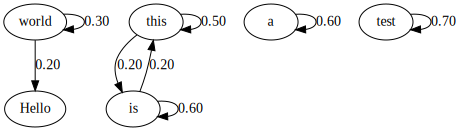

In [40]:
tokens = ['Hello', 'world', 'this', 'is', 'a', 'test']
# Example attention matrix (normally this should be output from a model)
attention_matrix = [
    [0.1, 0.2, 0, 0, 0, 0],
    [0.1, 0.3, 0, 0, 0, 0],
    [0, 0, 0.5, 0.2, 0.1, 0.1],
    [0, 0, 0.2, 0.6, 0.1, 0],
    [0, 0, 0.1, 0.1, 0.6, 0.1],
    [0, 0, 0, 0, 0.1, 0.7]
]
visualize_token_flow(tokens, attention_matrix)